wycinanie 0.2 + TTA = 0 i 180 rotacja -> 78.4 

wycinanie 0.25 -> 

wyciananie 0.2, ale poprawione był jeden błąd,złe TTA -> 0.785

wycinanie na 0.2 po poprawieniu, ale bez błędu w TTA - > 0.794

nie wczytywałem najlepszego modelu - >

zmiana na sigmoid, zmiana z one_hot_encoded na multilabel (ordinal_regression) 

In [1]:
import os
import json
import math

import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import gc

from matplotlib import ticker
from keras import layers, optimizers
from keras import Model
from keras.applications import DenseNet121
import random
# from keras.applications import VGG19
# from keras.applications.resnet50 import preprocess_input

from keras.callbacks import ModelCheckpoint
from keras.callbacks import LearningRateScheduler
from keras.callbacks import EarlyStopping
from keras.callbacks import Callback
from keras.models import Sequential

from imgaug import augmenters as iaa
from keras.utils import Sequence
from keras.utils import to_categorical

from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score

Using TensorFlow backend.


In [2]:
print(os.listdir("../input"))

path_train_img   = "../input/aptos2019-blindness-detection/train_images/" 
path_train_excel = "../input/aptos2019-blindness-detection/train.csv" 
test_csv = "../input/aptos2019-blindness-detection/test.csv" 

previous_train_csv =  "../input/previoussimilartoaptos/train_previous.csv"
previous_train_img_path   = "../input/previoussimilartoaptos/train_previous/"

df_train = pd.read_csv(path_train_excel)
df_train_previous = pd.read_csv(previous_train_csv)

sub = pd.read_csv('../input/aptos2019-blindness-detection/sample_submission.csv')    


image_size = 224

sometimes = lambda aug: iaa.Sometimes(0.5, aug)
pixels_augment = sometimes(
        iaa.OneOf([
            iaa.Add((-10, 10), per_channel=0.5),
            iaa.Multiply((0.9, 1.1), per_channel=0.5),
            iaa.ContrastNormalization((0.9, 1.1), per_channel=0.5),
        ])
    )
seq = iaa.Sequential([
    pixels_augment,
    iaa.Affine(
        rotate=(-180, 180),
        shear=(-6, 6)
    ),
#     iaa.CoarseDropout(p=0.01,size_percent=0.02)
],random_order=True)
seq_cropped = iaa.Sequential([
#     iaa.Fliplr(0.5),
#     iaa.Flipud(0.5),
    pixels_augment,
    iaa.Affine(
        rotate=(-10, 10),
        shear=(-6, 6)
    ),
#     iaa.CoarseDropout(p=0.015,size_percent=0.01)
],random_order=True)


def rotateAndScale(img, scaleFactor = 0.5, degreesCCW = 30):
    (oldY,oldX) = img.shape[0],img.shape[1] #note: numpy uses (y,x) convention but most OpenCV functions use (x,y)
    M = cv2.getRotationMatrix2D(center=(oldX/2,oldY/2), angle=degreesCCW, scale=scaleFactor) #rotate about center of image.

    newX,newY = oldX*scaleFactor,oldY*scaleFactor
    
    r = np.deg2rad(degreesCCW)
    newX,newY = (abs(np.sin(r)*newY) + abs(np.cos(r)*newX),abs(np.sin(r)*newX) + abs(np.cos(r)*newY))

    (tx,ty) = ((newX-oldX)/2,(newY-oldY)/2)
    M[0,2] += tx #third column of matrix holds translation, which takes effect after rotation.
    M[1,2] += ty

    rotatedImg = cv2.warpAffine(img, M, dsize=(int(newX),int(newY)))
    return rotatedImg

def augment_image(image, threshold=12):
    if len(image.shape) == 3:
        flatimage = np.max(image, 2)
    else:
        flatIimage = image
    assert len(flatimage.shape) == 2

    rows = np.where(np.max(flatimage, 0) > threshold)[0]
    
    if rows.size:
        cols = np.where(np.max(flatimage, 1) > threshold)[0]
        diff = abs(rows.size - cols.size)
        crop_percent = 0.2
        if diff < 100:
            image = seq.augment_image(image)
            start_cols = random.randint(0,int(cols[0] + crop_percent*cols[-1]))
            end_cols = random.randint(int(cols[-1] - crop_percent*cols[-1]),int(image.shape[0]))
            
            start_rows = random.randint(0,int(rows[0] + crop_percent*rows[-1]))
            end_rows = random.randint(int(rows[-1] - crop_percent*rows[-1]),int(image.shape[1]))
            image = image[start_cols: end_cols, start_rows: end_rows]
        else:
#             image = seq_cropped.augment_image(image)
            start_rows = random.randint(0,int(rows[0] + crop_percent*rows[-1]))
            end_rows = random.randint(int(rows[-1] - crop_percent*rows[-1]),int(image.shape[1]))
            image = image[:, start_rows: end_rows]
            image = rotateAndScale(image, scaleFactor = 0.5, degreesCCW = random.randint(0,360))
    else:
        image = image[:1, :1]

        
    return image

['model-pretrained-retina-gaussian', 'previoussimilartoaptos', 'aptos2019-blindness-detection']


In [3]:
def read_image(ID):
    if(ID.endswith("left") or ID.endswith("right")):
        img = cv2.imread(previous_train_img_path+"{}.jpeg".format(ID))
    else:
        img = cv2.imread(path_train_img+"{}.png".format(ID))

    return img

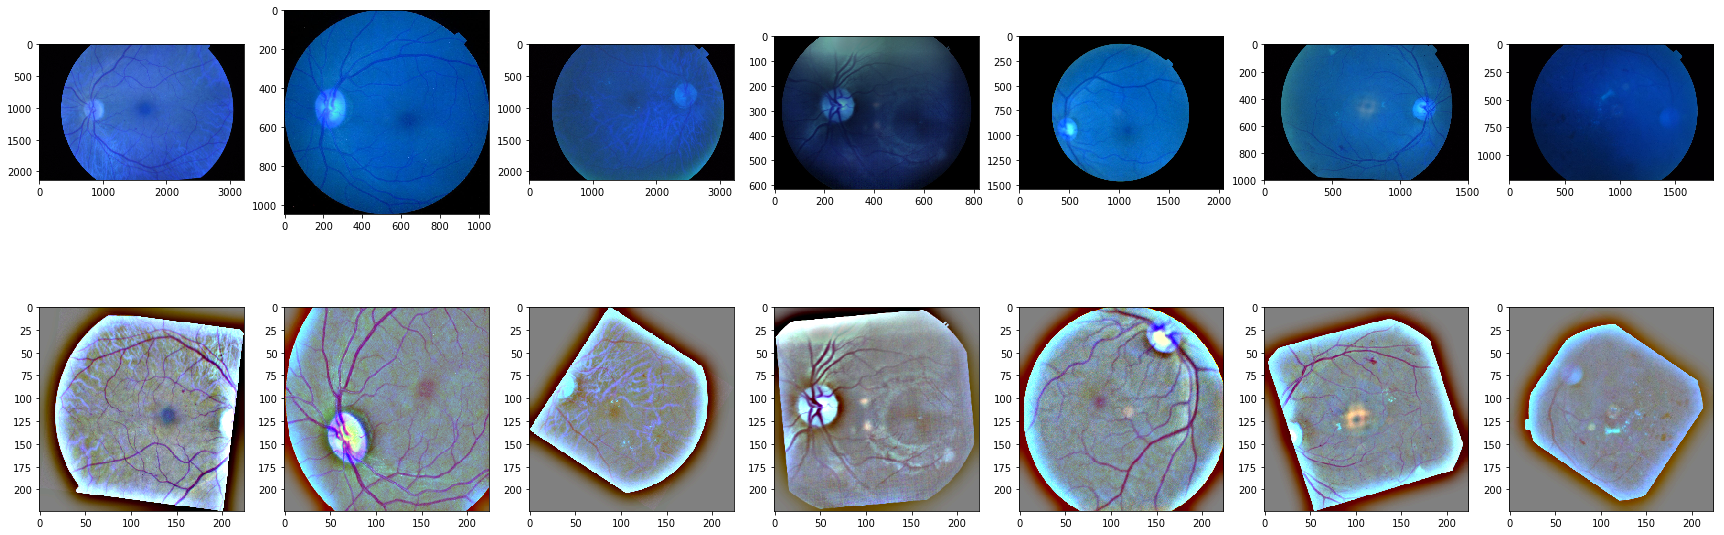

In [4]:
fig,ax = plt.subplots(2,7,figsize=(30,10))
for it,ID in enumerate(df_train["id_code"][14:21]):
    img = cv2.imread("../input/aptos2019-blindness-detection/train_images/{}.png".format(ID))          
    aug_img = augment_image(img)
    aug_img = cv2.resize(aug_img, (image_size,image_size))
    
    aug_img = cv2.addWeighted(aug_img,4,cv2.GaussianBlur(aug_img,(0,0) ,10) ,-4,128)
    
    ax[0][it].imshow(img)
    ax[1][it].imshow(aug_img)


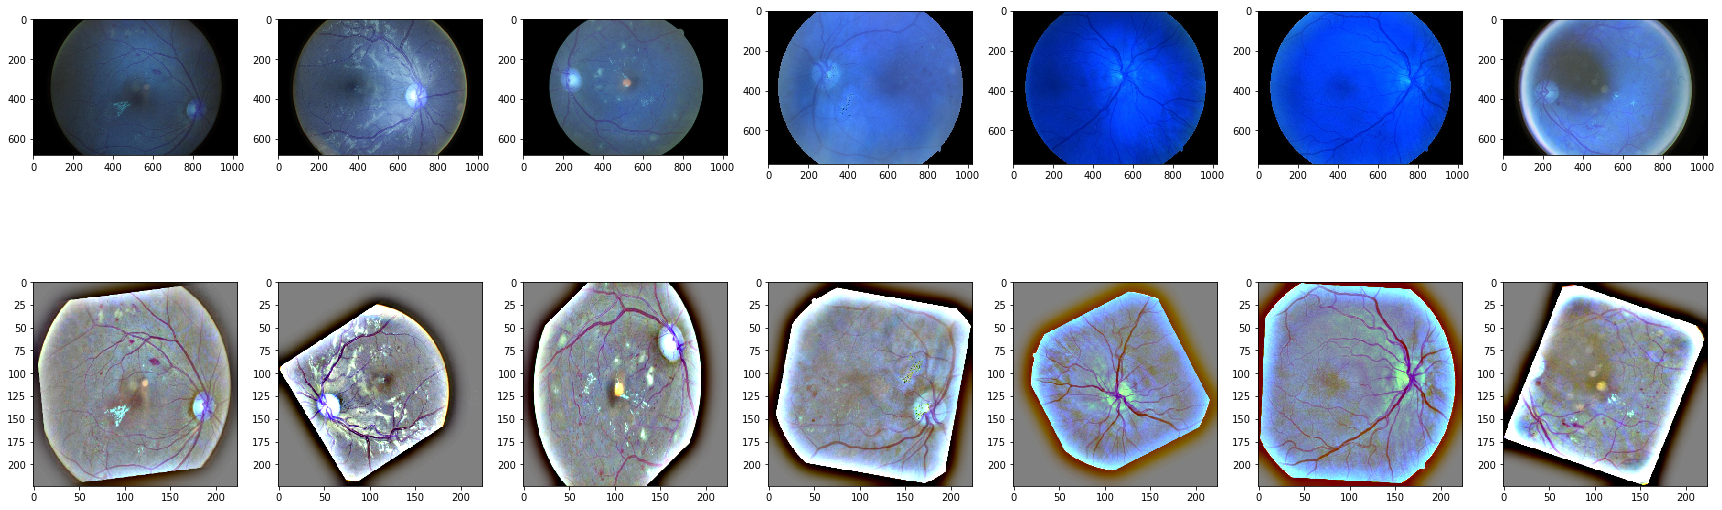

In [5]:
fig,ax = plt.subplots(2,7,figsize=(30,10))
for it,ID in enumerate(df_train_previous["id_code"][14:21]):
    img = read_image(ID)         
    aug_img = augment_image(img)
    aug_img = cv2.resize(aug_img, (image_size,image_size))

    aug_img = cv2.addWeighted(aug_img,4,cv2.GaussianBlur(aug_img,(0,0) ,10) ,-4,128)

    ax[0][it].imshow(img)
    ax[1][it].imshow(aug_img)

In [6]:
class DataGenerator(Sequence):
    'Generates data for Keras'
    def __init__(self, list_IDs, labels, batch_size=32, dim=(224,224), n_channels=3,
                 n_classes=5, shuffle=True,augment=True,is_mix=False):
        'Initialization'
        self.dim = dim
        self.batch_size = batch_size
        self.labels = labels
        self.list_IDs = list_IDs
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.shuffle = shuffle
        self.augment = augment
        self.is_mix = is_mix
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.list_IDs) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        IDs = self.list_IDs[index*self.batch_size:(index+1)*self.batch_size]
        labels = self.labels[index*self.batch_size:(index+1)*self.batch_size]

        # Generate data
        X, y = self.__data_generation(IDs,labels)

        return X, y

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)
    def mix_up(self, x, y):
        lam = np.random.beta(0.2, 0.4)
        ori_index = np.arange(int(len(x)))
        index_array = np.arange(int(len(x)))
        np.random.shuffle(index_array)        
        
        mixed_x = lam * x[ori_index] + (1 - lam) * x[index_array]
        mixed_y = lam * y[ori_index] + (1 - lam) * y[index_array]
        
        return mixed_x, mixed_y
    
    def __data_generation(self, list_IDs_temp,list_y_temp):
        'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)
        # Initialization
        X = np.empty((self.batch_size, *self.dim, self.n_channels))
        y = np.empty((self.batch_size), dtype=int)
    
        # Generate data
        for i, (ID,label) in enumerate(zip(list_IDs_temp,list_y_temp)):
            img = read_image(ID)
            
#             img = cv2.imread("../input/aptos2019-blindness-detection/train_images/{}.png".format(ID))
#             cropped = autocrop(img, threshold=12)
            if self.augment:
               img = augment_image(img)
            img = cv2.resize(img, self.dim)
            img = cv2.addWeighted(img,4,cv2.GaussianBlur(img,(0,0) ,10) ,-4,128)            
            
            X[i,] = img
            # Store class
            y[i] = label
        if(self.is_mix):
            X,y = self.mix_up(X, y)
        one_encoded = to_categorical(y, num_classes=self.n_classes, dtype='int8')
#         for i in range(y.shape[0]):
#             one_encoded[i,:y[i]]=1
        return X/255.,one_encoded
#         return X/255.,y
    

#get validation set from original data set and training as concatenation what has left + previous
skf = StratifiedKFold(n_splits=10,random_state=2019)
train_index, test_index = next(skf.split(df_train["id_code"],df_train["diagnosis"]))
X_train,X_val = df_train["id_code"].iloc[train_index], df_train["id_code"].iloc[test_index]
y_train,y_val = df_train["diagnosis"][train_index], df_train["diagnosis"][test_index]

# X_train_concat = pd.concat([X_train,df_train_previous["id_code"]])
# y_train_concat = pd.concat([y_train,df_train_previous["diagnosis"]])

#define train and validation generator
train_gen = DataGenerator(X_train,y_train,n_classes=y_train.unique().shape[0],batch_size=32,augment=True,dim=(image_size,image_size))
valid_gen = DataGenerator(X_val, y_val,n_classes=y_train.unique().shape[0],augment=False,dim=(image_size,image_size))
# valid_gen_aug = DataGenerator(X_val, y_val,n_classes=y_train.unique().shape[0],augment=True)

In [7]:
epochs = 20
tta_steps = 8
if sub.shape[0] < 2000:
    epochs = 10
    tta_steps = 1


In [8]:
inp = layers.Input(shape=(None, None, 3), name='image_input')
base_model = DenseNet121(include_top=False,
                   weights=None,input_tensor=inp)
# base_model = VGG19(include_top=False,
#                    weights='../input/vgg19/vgg19_weights_tf_dim_ordering_tf_kernels_notop.h5',input_tensor=inp)



x = layers.GlobalAveragePooling2D()(base_model.output)
x = layers.Dropout(0.4)(x)
x = layers.Dense(2048,activation='relu')(x) 
x = layers.Dropout(0.4)(x)
x = layers.Dense(2048,activation='relu')(x)
x = layers.Dropout(0.4)(x)
x = layers.Dense(5, activation='softmax', name='predictions')(x)
# x = layers.Dense(5, activation='sigmoid', name='predictions')(x)
# x = layers.Dense(1, name='predictions_MSE')(x)

model = Model(inputs=inp, outputs=x)
model.load_weights('../input/model-pretrained-retina-gaussian/model.h5', by_name=True)


# Compile Model
from keras import backend as K

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

model.compile(loss='categorical_crossentropy', optimizer=optimizers.Adam(lr=1e-4),metrics=["accuracy",f1_m,precision_m, recall_m])
# model.compile(loss='MSE', optimizer=optimizers.Adam(lr=1e-4),metrics=["MSE"])

def scheduler(epoch,learning_rate):
    lr = learning_rate
    if epoch==3:
        lr = 7e-5
    if epoch==6:
        lr = 4e-5
    if epoch==9:
        lr = 1e-5
    if epoch==12:
        lr = 8e-6
    return lr
#add class weight to work with imbalance
# class_weights = {cl: df_train.shape[0] / df_train[df_train["diagnosis"]==cl].shape[0] for cl in y_train.unique()}
from sklearn.utils.class_weight import compute_sample_weight
y_train_weight = compute_sample_weight("balanced", np.unique(y_train), y_train)

checkpoint = ModelCheckpoint('model.h5', save_best_only=True,verbose=1,monitor='val_recall_m',mode='max')
# checkpoint = ModelCheckpoint('model.h5', save_best_only=True,verbose=1,monitor='val_loss',mode='min')
learning_scheduler = LearningRateScheduler(scheduler,verbose=1)
# es = EarlyStopping(monitor='val_loss',mode='min', patience=5, verbose=0)
es = EarlyStopping(monitor='val_acc',mode='max', patience=5, verbose=0)



history = model.fit_generator(train_gen,verbose=1,epochs=epochs,validation_data=valid_gen, callbacks=[checkpoint,learning_scheduler,es],class_weight=y_train_weight)

Epoch 1/10

Epoch 00001: LearningRateScheduler setting learning rate to 9.999999747378752e-05.
102/102 [==============================] - 529s 5s/step - loss: 0.5582 - acc: 0.7935 - f1_m: 0.7815 - precision_m: 0.8316 - recall_m: 0.7393 - val_loss: 0.6636 - val_acc: 0.7557 - val_f1_m: 0.7425 - val_precision_m: 0.8290 - val_recall_m: 0.6733

Epoch 00001: val_recall_m improved from -inf to 0.67330, saving model to model.h5
Epoch 2/10

Epoch 00002: LearningRateScheduler setting learning rate to 9.999999747378752e-05.
102/102 [==============================] - 455s 4s/step - loss: 0.4850 - acc: 0.8143 - f1_m: 0.8093 - precision_m: 0.8490 - recall_m: 0.7745 - val_loss: 0.6799 - val_acc: 0.7528 - val_f1_m: 0.7351 - val_precision_m: 0.8238 - val_recall_m: 0.6648

Epoch 00002: val_recall_m did not improve from 0.67330
Epoch 3/10

Epoch 00003: LearningRateScheduler setting learning rate to 9.999999747378752e-05.
102/102 [==============================] - 521s 5s/step - loss: 0.4620 - acc: 0.8260

In [9]:
path_test_img = "../input/aptos2019-blindness-detection/test_images"
path_test_excel = "../input/aptos2019-blindness-detection/sample_submission.csv"

df_test = pd.read_csv(path_test_excel)
df_test["diagnosis"] = np.random.randint(5, size=df_test.shape[0])

# tta_steps = 10

scores_predicted = np.empty([tta_steps,len(df_test),y_train.unique().shape[0]])
model.load_weights('model.h5')
for step in range(tta_steps):
    for i, name in enumerate(df_test['id_code']):
        path = os.path.join('../input/aptos2019-blindness-detection/test_images/', name+'.png')
        
        image = cv2.imread(path)
        image = rotateAndScale(image, scaleFactor = 0.5, degreesCCW = step*45)
        image = cv2.resize(image, (image_size,image_size))
        image = cv2.addWeighted(image,4,cv2.GaussianBlur(image,(0,0) ,10) ,-4,128)

        score_predict = model.predict((image[np.newaxis])/255)
        scores_predicted[step,i,:] = score_predict
#         label_predict = np.argmax(score_predict)
#         predicted.append(str(label_predict))
        if i%200 == 0:
            print('Numer added: {}/{}'.format(i,df_test['id_code'].size))

Numer added: 0/1928
Numer added: 200/1928
Numer added: 400/1928
Numer added: 600/1928
Numer added: 800/1928
Numer added: 1000/1928
Numer added: 1200/1928
Numer added: 1400/1928
Numer added: 1600/1928
Numer added: 1800/1928


In [10]:
# (scores_predicted.mean(axis=0)[:,::-1]>0.5).argmax(axis=1)

In [11]:
predicted = np.argmax(scores_predicted.mean(axis=0),axis=1)
# predicted = (scores_predicted.mean(axis=0)[:,::-1]>0.5).argmax(axis=1)
df_test['diagnosis'] = predicted
df_test.to_csv('submission.csv',index=False)

df_test["diagnosis"].describe()

count    1928.000000
mean        1.596473
std         0.948617
min         0.000000
25%         1.000000
50%         2.000000
75%         2.000000
max         4.000000
Name: diagnosis, dtype: float64

../input/aptos2019-blindness-detection/test_images/0005cfc8afb6.png
../input/aptos2019-blindness-detection/test_images/003f0afdcd15.png
../input/aptos2019-blindness-detection/test_images/006efc72b638.png
../input/aptos2019-blindness-detection/test_images/00836aaacf06.png
../input/aptos2019-blindness-detection/test_images/009245722fa4.png
../input/aptos2019-blindness-detection/test_images/009c019a7309.png
../input/aptos2019-blindness-detection/test_images/010d915e229a.png


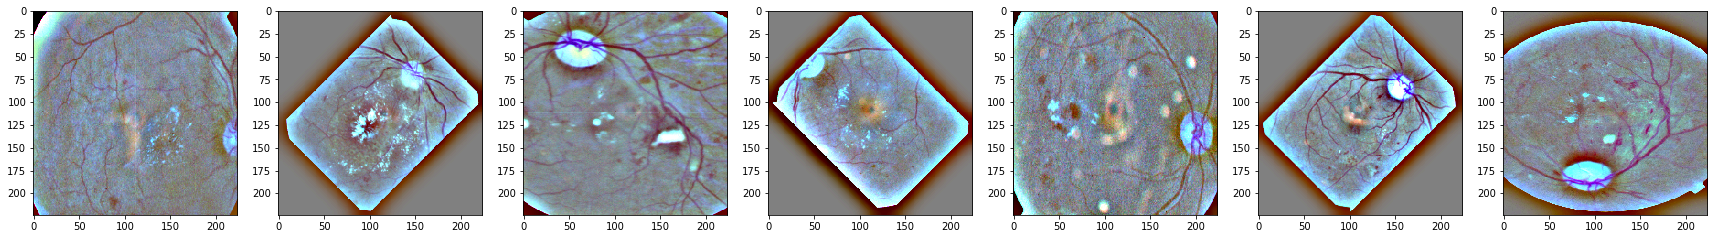

In [12]:
fig,ax = plt.subplots(1,7,figsize=(30,10))
for i, name in enumerate(df_test['id_code'].iloc[0:7]):
        path = os.path.join('../input/aptos2019-blindness-detection/test_images/', name+'.png')
        print(path)
        
        image = cv2.imread(path)
        image = rotateAndScale(image, scaleFactor = 0.5, degreesCCW = i*45)
        image = cv2.resize(image, (image_size,image_size))
        image = cv2.addWeighted(image,4,cv2.GaussianBlur(image,(0,0) ,10) ,-4,128)
        ax[i].imshow(image)

In [13]:
df_test.head()

,id_code,diagnosis
0,0005cfc8afb6,1
1,003f0afdcd15,2
2,006efc72b638,2
3,00836aaacf06,2
4,009245722fa4,2


In [14]:
path = os.path.join('../input/aptos2019-blindness-detection/test_images/', '2febc332f628.png')
        
image = cv2.imread(path)
image = rotateAndScale(image, scaleFactor = 0.5, degreesCCW = 0)
image = cv2.resize(image, (image_size,image_size))
image = cv2.addWeighted(image,4,cv2.GaussianBlur(image,(0,0) ,10) ,-4,128)

score_predict = model.predict((image[np.newaxis])/255)
np.where(score_predict>0.5)[1].max()

2

In [15]:
score_predict

array([[0.00102215, 0.0328632 , 0.7115167 , 0.13926837, 0.11532959]],
      dtype=float32)

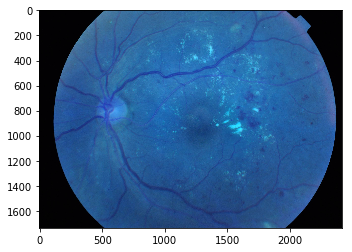

In [16]:
image = cv2.imread(path)
plt.imshow(image)